In [1]:
import mpbn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1000 models

In [2]:
modelname = []
modelname.extend([f"models/bn{n}.bnet" for n in range(1000)])

solutions = list()
for i,n in enumerate(modelname):
    solutions.append(mpbn.MPBooleanNetwork(f"{n}"))

`clauses_per_model` : list of models, each model being a dictionary
* keys = **model's nodes** 
* value = a set (-> **the clauses constituting the node's function in the model**)

In [3]:
# For each model, I store the clauses per node
clauses_per_model = list() #Each element of this list will correspond to a model, it's a dict linking nodes and their clauses.
for i, model in enumerate(solutions): #We go through the 1000 models.
    clauses_of_a_node = dict() #The dict that will link a node to its clauses.
    for node in model.keys(): #We go through the nodes of the model.
        #if not isinstance(model[node],frozenset):
        if model[node]==True or model[node]==False :
            clauses_of_a_node[node] = model[node]
        else:
            clauses_of_a_node[node] = mpbn.minibn.struct_of_dnf(model.ba, model[node]) #We store the clauses ruling this node.
    clauses_per_model.append(clauses_of_a_node) #Now that all nodes are linked with their clauses, we save this information as a new element in clauses_per_model.

`dico` : dictionnary
* keys = **model's nodes** 
* value = dictionary  
     + keys = **its inhibitors and activators**
     + value = **number of models having this inhibitor/activator in the node's function**

`constantes` : dictionnary
* keys = **model's nodes with at least one constant function in a model (constant function : 1 or 0)**
* value = dictionnary
     + key = **value of the constant function (TRUE for 1, FALSE for 0)**
     + value = **number of models having 1 or 0 as function for the node**

In [4]:
dico = dict()
constantes = dict()
for model in clauses_per_model:
    for node, influenceurs_set in model.items():
        temp = set()
        if node not in dico:
            dico[node] = dict()
        #print(influenceurs_set)
        #print(type(influenceurs_set))
        #print(isinstance(influenceurs_set, bool))
        if influenceurs_set != True and influenceurs_set != False:
            for conjonctions in influenceurs_set:
                for clause in conjonctions:
                    if clause[0] not in temp:
                        temp.add(clause[0])
                        if clause[0] not in dico[node]:
                            dico[node][clause[0]] = dict()
                            dico[node][clause[0]][clause[1]] = 1
                        elif clause[1] not in dico[node][clause[0]]:
                            dico[node][clause[0]][clause[1]] = 1
                        else:
                            dico[node][clause[0]][clause[1]] += 1
        else:
            if node not in constantes:
                constantes[node] = dict()
            if influenceurs_set not in constantes[node]:
                constantes[node][influenceurs_set] = 1
            else:
                constantes[node][influenceurs_set] += 1

## Clusters among the ensemble of models ?

Use of 2 methods:
* MDS (MultiDimensional Scaling)
* agglomerative hierarchical clustering

In order to use these methods, it was necessary to determine a distance metric between the models. This "inter-BN" distance is the following:  
**Given $m_1$ and $m_2$ two Boolean networks of dimension $n$,  
the distance "inter-BN" $d(m_1,m_2) = \sum_{i=1}^{n} \mathbb{1}(m_{1}[i] \neq m_{2}[i])$**

Depending on the random seed used for the MDS, we get 3 or 4 clusters. Among them, 2 clusters are always strictly identical. For the following ones, two scenarios depending on whether there are 3 or 4 clusters in total:

* **In the case of the division into 4 clusters,** the division between the 2 remaining groups is unstable depending on the random seed used for the calculation. For example:
   - **4+1 :** $[0, 93, 675, 966]$ et $[1]$
   - **3+2 :** $[93, 675, 966]$ et $[0, 1]$
* **In the case of the division into 3 clusters,** the clusters remain identical regardless of the random seeds tested. Cluster 3 being :
   - $[0, 1, 93, 675, 966]$


Hierarchical 3-cluster clustering results in exactly the same 3 clusters as 3-cluster MDS. Hierarchical clustering into 4 clusters leads to the following division:
* $[0, 1, 93, 966]$ et $[675]$

Given the consistency of the division into 3 clusters, this clustering appears to be the most relevant.

In [5]:
# packages pour calculer MDS et AgglomerativeClustering + scatterplot et dendrogram
import sklearn as sk
from sklearn import manifold
from sklearn import cluster
import sklearn.datasets as dt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

In [6]:
df_models = pd.DataFrame(clauses_per_model)

### Creation of the distance matrix

In [ ]:
dissimilarity_matrix = np.zeros((1000,1000))

for i in range(0,1000):
    for j in range(i+1,1000):
        distance = 0
        for node in dico.keys():
            if df_models.loc[i,node] != df_models.loc[j,node]:
                distance += 1
        dissimilarity_matrix[i,j] = distance
        dissimilarity_matrix[j,i] = distance

Si besoin :

In [ ]:
# saving the similarity matrix:
import pickle
with open('data/analysis/dissimilarity_matrix_1000.binary', 'wb') as f:
    pickle.dump(dissimilarity_matrix, f)

In [8]:
# recovery of the similarity matrix:
import pickle
with open('data/analysis/dissimilarity_matrix_1000.binary', 'rb') as f:
    dissimilarity_matrix = pickle.load(f)

### MDS

In [ ]:
# To display the figures outside the notebook :
%matplotlib qt

#### MDS 2D

**Large majority of random seeds: 3 clusters.**  
Example here with seed 10:

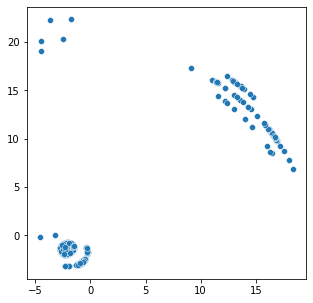

In [14]:
mds = manifold.MDS(
    dissimilarity="precomputed", 
    random_state=10 #3 pour 250
)
npos = mds.fit_transform(dissimilarity_matrix)

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos[:, 0], y=npos[:, 1])

**Seeds resulting in 4 clusters constantly split the same cluster, but in an unstable way (it is not constantly the same models which are separated).**  
Example here with seed 12:

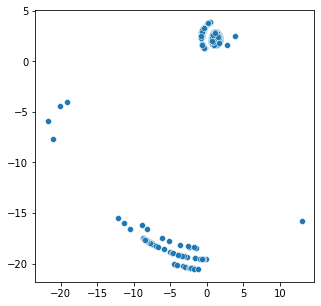

In [15]:
mds_4c = manifold.MDS(
    dissimilarity="precomputed", 
    random_state=12  #,n_jobs=-1 : pour calculer en utilisant tous les cœurs.
) 
npos_4c = mds_4c.fit_transform(dissimilarity_matrix)

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos_4c[:, 0], y=npos_4c[:, 1])

#### MDS 3D
Does not allow to refine the clustering compared to 2D.

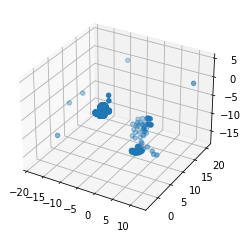

In [11]:
mds_3D = manifold.MDS(
    n_components=3,
    dissimilarity="precomputed"
)
npos_3D = mds_3D.fit_transform(dissimilarity_matrix)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = npos_3D[:, 0]
ys = npos_3D[:, 1]
zs = npos_3D[:, 2]
ax.scatter(xs, ys, zs)

#### Analysis of MDS 2D, 3 clusters (random seed n°10):

Position of the different clusters in the 2D graph:
* $y < 2$
* $x < 0, y > 15$
* $x > 5$

##### 1) Plot : highlighting clusters with different colors.

In [16]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster0 ou non.
cluster0_x = npos[:,0] < 0
cluster0_y = npos[:,1] > 15
cluster0 = cluster0_x & cluster0_y

cluster0_indices = list()
for i in range(0,npos.shape[0]):
    if cluster0[i]:
        cluster0_indices.append(i)
len(cluster0_indices)

5

In [ ]:
cluster0_indices

In [17]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster1 ou non.
cluster1 = npos[:,1] < 2

cluster1_indices = list()
for i in range(0,npos.shape[0]):
    if cluster1[i]:
        cluster1_indices.append(i)
len(cluster1_indices)

885

In [ ]:
cluster1_indices

In [18]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster2 ou non.
cluster2 = npos[:,0] > 5

cluster2_indices = list()
for i in range(0,npos.shape[0]):
    if cluster2[i]:
        cluster2_indices.append(i)
len(cluster2_indices)

110

In [ ]:
cluster2_indices

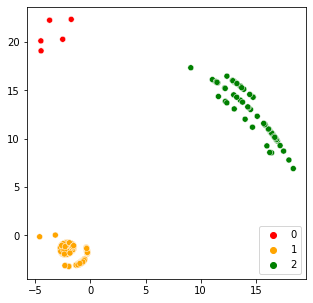

In [21]:
# Scatterplot coloré par cluster :

categories = list()
for i in range(0,1000):
    if cluster0[i]:
        categories.append(0)
    elif cluster1[i]:
        categories.append(1)
    elif cluster2[i]:
        categories.append(2)

correspondance_couleur = {0:'red', 1:'orange', 2:'green'}

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos[:, 0], y=npos[:, 1], hue=categories, palette=correspondance_couleur)
plt.legend(loc='lower right')

#### Agglomerative hierarchical clustering

In [22]:
clustering = cluster.AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average", compute_distances=True).fit(dissimilarity_matrix)

Are there differences between the clustering in 3 groups obtained by the MDS and by the aggl. clustering? To do this, search for a bijection:

In [24]:
dist_clusterings = 0
for i in range(0,1000):
    if clustering.labels_[i] != categories[i]:
        dist_clusterings += 1
        print(f"{i}eme BN: {categories[i]} vs {clustering.labels_[i]}")
print(f"{dist_clusterings} differences between the clustering obtained by MDS and that obtained by AggClust.")

0 differences between the clustering obtained by MDS and that obtained by AggClust.


In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

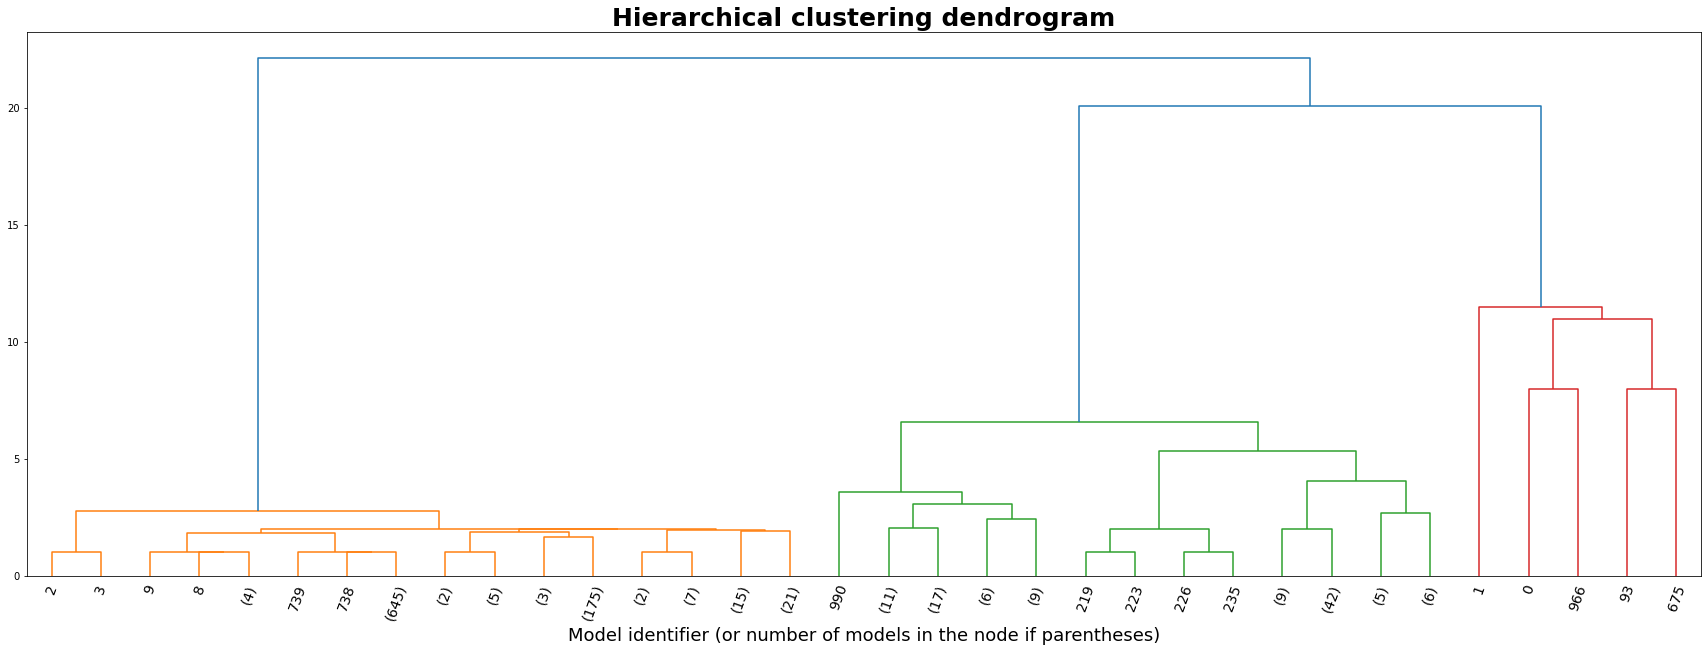

In [29]:
f = plt.figure(figsize=(30, 10))
plt.title("Hierarchical clustering dendrogram", fontsize=25, weight='bold')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=5, leaf_font_size=14, leaf_rotation=70)
plt.xlabel("Model identifier (or number of models in the node if parentheses)", fontsize=18)
plt.show()

## Clusters analysis : compare functions within clusters.

In [30]:
def common_and_distinct_functions(dico, clauses_per_model, cluster_indices):
    clauses_en_commun = clauses_per_model[cluster_indices[0]].copy()
    fonctions_differentes = dict()
    
    for node in dico.keys():
        if node not in fonctions_differentes:
            fonctions_differentes[node] = set()
            fonctions_differentes[node].add(clauses_per_model[cluster_indices[0]][node])
        for indice in cluster_indices:
            if clauses_per_model[indice][node] != fonctions_differentes[node]:
                fonctions_differentes[node].add(clauses_per_model[indice][node])
            if node in clauses_en_commun:
                if clauses_per_model[indice][node] != clauses_en_commun[node]:
                    del clauses_en_commun[node]
    
    clauses = clauses_per_model[cluster_indices[0]].copy()
    for node in clauses_en_commun.keys():
        del clauses[node]
    
    clauses_differentes = (clauses.keys(), fonctions_differentes)
    
    return clauses_en_commun, clauses_differentes

In [50]:
def intra_cluster_comparison(cluster_id, clauses, cluster_indices, flag: bool = True):
    flag_text = "identical" if flag else "different"

    with open(f"data/analysis/{cluster_id}_comparison.txt", "w") as f:
        f.write(f"{len(clauses[0])} nodes have {flag_text} fonctions among {len(cluster_indices)} BNs : {list(clauses[0])}")
    
        for node in clauses[0]:
            f.write(f"\n--- {node:<7} : {len(clauses[1][node])} different fonctions:")
            for fonction in clauses[1][node]:
                f.write(f" >> {fonction}")

In [47]:
clauses_en_commun_cluster0, clauses_distinctes_cluster0 = common_and_distinct_functions(dico, clauses_per_model, cluster0_indices)
clauses_en_commun_cluster1, clauses_distinctes_cluster1 = common_and_distinct_functions(dico, clauses_per_model, cluster1_indices)
clauses_en_commun_cluster2, clauses_distinctes_cluster2 = common_and_distinct_functions(dico, clauses_per_model, cluster2_indices)

In [51]:
intra_cluster_comparison("red", clauses_distinctes_cluster0, cluster0_indices, flag=False)

In [42]:
intra_cluster_comparison("orange"clauses_distinctes_cluster1, cluster1_indices, flag=False)

4 nodes have different fonctions among 885 BNs : ['CREM', 'FOS', 'IKZF1', 'TRP53']

--- CREM    : 2 different fonctions:
 >> frozenset({frozenset({('STAT1', True), ('JUN', True), ('SP1', True)}), frozenset({('STAT1', True), ('JUN', True), ('FOS', True)})})
 >> frozenset({frozenset({('STAT1', True), ('JUN', True), ('FOS', True)}), frozenset({('STAT1', True), ('SP1', True), ('FOS', True)})})

--- FOS     : 661 different fonctions:
 >> frozenset({frozenset({('STAT3', True), ('ESR1', True), ('SP1', True), ('SPI1', True), ('TRP53', True)}), frozenset({('STAT3', True), ('CREM', False), ('FLI1', True)}), frozenset({('STAT6', True), ('SP1', True), ('FLI1', True), ('ESR1', True)}), frozenset({('JUN', True), ('ESR1', True), ('CREM', False), ('SPI1', True), ('FLI1', True), ('TRP53', True)}), frozenset({('SP1', True), ('JUN', True), ('FLI1', True), ('ESR1', True)}), frozenset({('JUN', True), ('STAT3', True), ('SP1', True), ('CREM', False), ('SPI1', True), ('TRP53', True)}), frozenset({('JUN', True

In [43]:
display_intra_cluster_comparison(clauses_distinctes_cluster2, cluster2_indices, flag=False)

12 nodes have different fonctions among 110 BNs : ['FLI1', 'FOS', 'HNF4A', 'IRF2', 'KLF6', 'MEF2C', 'MYB', 'MYC', 'RUNX1', 'STAT1', 'TCF12', 'TRP53']

--- FLI1    : 3 different fonctions:
 >> frozenset({frozenset({('EBF1', True)})})
 >> frozenset({frozenset({('MEF2C', True), ('EBF1', True)})})
 >> frozenset({frozenset({('MEF2C', True), ('EBF1', True)}), frozenset({('EBF1', True), ('SPI1', True)})})

--- FOS     : 17 different fonctions:
 >> frozenset({frozenset({('JUN', True), ('SP1', True), ('SPI1', True)}), frozenset({('JUN', True), ('TRP53', True), ('ESR1', True)}), frozenset({('STAT1', True), ('STAT6', True)}), frozenset({('STAT3', True), ('CREM', False), ('FLI1', True)}), frozenset({('STAT3', True), ('JUN', True), ('CREM', False)}), frozenset({('FLI1', True), ('SPI1', True), ('TRP53', True)}), frozenset({('SP1', True), ('CREM', False), ('SPI1', True), ('FLI1', True)}), frozenset({('SP1', True), ('JUN', True), ('FLI1', True), ('ESR1', True)})})
 >> frozenset({frozenset({('JUN', Tru

## Evolution of raw expression values, along the differentiation trajectory:

memo for scatterplot :
* S1 S0 S3 S5 : 1323 points <-> 13.23 in
* S1 S0 S3 S4 : 903 points <-> 9.03
* S1 S0 S2 : 747 points <-> 7.47

**EN COURS**